# Lecture 12 - Self-Supervised Learning

```{contents}
:local:
:depth: 1
```

## Learning goals

- Build **clustering** workflows: pick features, scale, fit, visualize.
- Choose and justify distance metrics for descriptors vs fingerprints.
- Select k and model type using elbow and silhouette.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1CGznPlVhSet10f820k7TyPvk3kcBdHkC?usp=sharing)


## 1. Setup

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import pairwise_distances

# RDKit
try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem, rdFingerprintGenerator, DataStructs
    RD = True
except Exception:
    try:
        %pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem, rdFingerprintGenerator, DataStructs
        RD = True
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        RD = False
        Chem = None

# UMAP install guard
try:
    import umap
    from umap import UMAP
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False

import warnings
warnings.filterwarnings("ignore")

## 2. Data Loading

Similar to we we did before, let's first make small helper to compute 4 quick descriptors and a compact fingerprint.

In [2]:
def calc_desc4(smiles: str):
    if not RD:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

def morgan_bits(smiles: str, n_bits: int = 128, radius: int = 2):
    if not RD:
        return np.zeros(n_bits, dtype=int)
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return np.zeros(n_bits, dtype=int)
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp = gen.GetFingerprint(m)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Load the same C-H oxidation dataset used in Lectures 7 and 11.

In [3]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


Compute features we will use today and keep the `Reactivity` column for later evaluation.

In [4]:
desc = df_raw["SMILES"].apply(calc_desc4)
df = pd.concat([df_raw, desc], axis=1)

# fingerprint matrix as 0 or 1
FP_BITS = 128
fp_mat = np.vstack(df_raw["SMILES"].apply(lambda s: morgan_bits(s, n_bits=FP_BITS, radius=2)).values)

# a tidy feature table that has descriptors and the label of interest
cols_x = ["MolWt", "LogP", "TPSA", "NumRings"]
keep = ["Compound Name", "SMILES", "Reactivity"] + cols_x
frame = pd.concat([df[keep].reset_index(drop=True), pd.DataFrame(fp_mat, columns=[f"fp_{i}" for i in range(FP_BITS)])], axis=1)
frame.head()

,Compound Name,SMILES,Reactivity,MolWt,LogP,TPSA,NumRings,fp_0,fp_1,fp_2,...,fp_118,fp_119,fp_120,fp_121,fp_122,fp_123,fp_124,fp_125,fp_126,fp_127
0,"3,4-dihydro-1H-isochromene",c1ccc2c(c1)CCOC2,1,134.178,1.7593,9.23,2.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9H-fluorene,c1ccc2c(c1)Cc1ccccc1-2,1,166.223,3.2578,0.00,3.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,"1,2,3,4-tetrahydronaphthalene",c1ccc2c(c1)CCCC2,1,132.206,2.5654,0.00,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ethylbenzene,CCc1ccccc1,1,106.168,2.2490,0.00,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cyclohexene,C1=CCCCC1,1,82.146,2.1166,0.00,1.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We will standardize the small descriptor block to avoid scale dominance.

In [5]:
scaler = StandardScaler().fit(frame[cols_x])
X_desc = scaler.transform(frame[cols_x])          # shape: n x 4
X_fp   = frame[[c for c in frame.columns if c.startswith("fp_")]].to_numpy().astype(float)  # n x 128
y_reac = frame["Reactivity"].astype(str)          # strings such as "low", "medium", "high" if available
X_desc[:2], X_fp.shape, y_reac.value_counts().to_dict()

(array([[-0.9608755 , -0.73344493, -0.77292513, -0.18998544],
        [-0.61504052,  0.1485916 , -1.07637154,  0.49277473]]),
 (575, 128),
 {'-1': 311, '1': 264})

In Lecture 11 we mapped high dimensional features to 2D for plots using PCA, t-SNE, and UMAP. Today we take the next step: form clusters that group similar molecules together. We will start simple and add checks.

Key ideas:

- Clustering uses only $X$. No label $y$ during fit.
- Distance matters. For descriptors we use Euclidean on standardized columns. For binary fingerprints many chemists prefer Tanimoto similarity, with distance $d_{\text{tan}} = 1 - s_{\text{tan}}$ where
  $
  s_{\text{tan}}(i,j) = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}.
  $

First let's do a quick 2D descriptor map to build intuition.

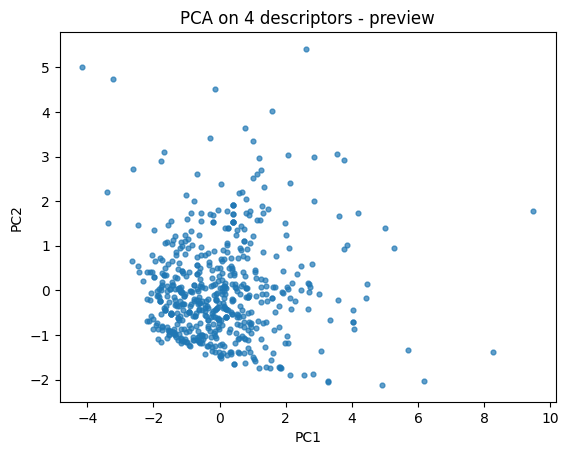

In [6]:
pca = PCA(n_components=2, random_state=0).fit(X_desc)
Z = pca.transform(X_desc)

plt.scatter(Z[:,0], Z[:,1], s=12, alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA on 4 descriptors - preview")
plt.show()

---




## 3. KMeans on clustering

We start with **KMeans** because it is one of the simplest and most widely used clustering algorithms. It gives us a baseline understanding of how groups may form in our dataset.

---

### 3.1 Fit KMeans for a single $k$

In clustering, $k$ is the number of groups we want to divide our data into.  
KMeans works by alternating between two steps:

1. **Assignment step**  
   Each data point $x_i$ is assigned to the nearest cluster center $c_j$ according to Euclidean distance:  

   $
   \text{assign}(x_i) = \arg \min_j \| x_i - c_j \|^2
   $

2. **Update step**  
   Each cluster center $c_j$ is updated to be the mean of all points assigned to it:  

   $
   c_j = \frac{1}{|S_j|} \sum_{x_i \in S_j} x_i
   $

The process repeats until the centers stabilize or a maximum number of iterations is reached.

The optimization goal is to minimize the **within-cluster sum of squares** (WCSS):

$
\min_{c_1, \dots, c_k} \sum_{j=1}^k \sum_{x_i \in S_j} \| x_i - c_j \|^2
$


Our descriptor space has 4 dimensions. To plot, we project the standardized descriptors into **2D PCA space**.  
This does not affect clustering (which is run in the original scaled space), but helps us visualize the results.

In [7]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X_desc)
labels_km = kmeans.labels_

pd.Series(labels_km).value_counts().sort_index()

0    126
1     96
2    353
Name: count, dtype: int64

Map clusters on our PCA plane.

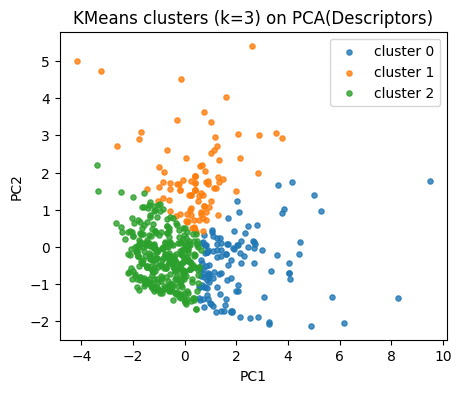

In [8]:
plt.figure(figsize=(5,4))
for lab in np.unique(labels_km):
    idx = labels_km == lab
    plt.scatter(Z[idx,0], Z[idx,1], s=14, alpha=0.8, label=f"cluster {lab}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("KMeans clusters (k=3) on PCA(Descriptors)")
plt.legend()
plt.show()

```{admonition} ⏰ **Exercise**
Try `k=2` and `k=4`.

```


Peek at cluster centers in the original descriptor space. We inverse transform to original units.

In [9]:
centroids_std = kmeans.cluster_centers_                           # in z space
centroids_orig = scaler.inverse_transform(centroids_std)          # back to original units
cent_tab = pd.DataFrame(centroids_orig, columns=cols_x)
cent_tab

,MolWt,LogP,TPSA,NumRings
0,329.155421,4.928251,32.210000,4.126984
1,262.400417,1.721370,81.844167,2.562500
2,174.739895,2.668183,19.575467,1.541076


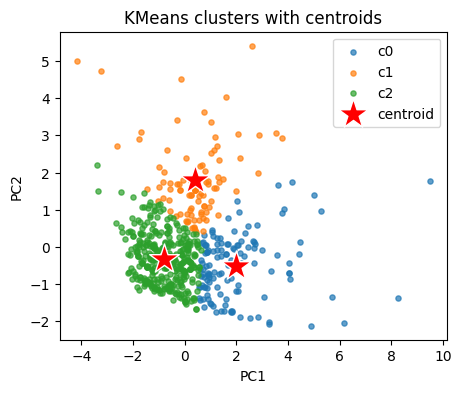

In [10]:
# Plot KMeans clusters with centroids as stars
plt.figure(figsize=(5,4))
for c in np.unique(labels_km):
    plt.scatter(Z[labels_km==c,0], Z[labels_km==c,1], s=14, alpha=0.7, label=f"c{c}")
cent_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(cent_pca[:,0], cent_pca[:,1], s=500, marker="*", c="red", edgecolor="w", label="centroid")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("KMeans clusters with centroids")
plt.legend(); plt.show()

### 3.2 What does a single sample look like

Sometimes it helps to print one row to see the scaled numbers and the assigned cluster.

In [11]:
i = 7
print("Compound:", frame.loc[i, "Compound Name"])
print("Original desc:", frame.loc[i, cols_x].to_dict())
print("Scaled desc:", dict(zip(cols_x, np.round(X_desc[i], 3))))
print("Cluster:", labels_km[i])

Compound: methoxymethylbenzene
Original desc: {'MolWt': 122.16699999999996, 'LogP': 1.8330000000000002, 'TPSA': 9.23, 'NumRings': 1.0}
Scaled desc: {'MolWt': np.float64(-1.091), 'LogP': np.float64(-0.69), 'TPSA': np.float64(-0.773), 'NumRings': np.float64(-0.873)}
Cluster: 2


### 3.3 KMeans on t-SNE and UMAP
Let's also take a look at how kmeans can be applied to t-SNE and UMAP we learned during the last lecture.

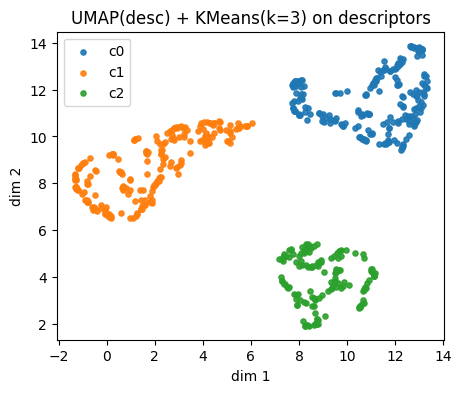

In [12]:
from sklearn.manifold import TSNE

def embed_descriptors(X, use_umap=True, random_state=0):
    if use_umap and HAVE_UMAP:
        reducer = UMAP(n_neighbors=15, min_dist=0.10, metric="euclidean", random_state=random_state)
        Z = reducer.fit_transform(X)
        name = "UMAP(desc)"
    else:
        reducer = TSNE(n_components=2, perplexity=30, learning_rate="auto",
                       init="pca", metric="euclidean", random_state=random_state)
        Z = reducer.fit_transform(X)
        name = "t-SNE(desc)"
    return Z, name

# 1) Embed descriptors
Z_desc, name_desc = embed_descriptors(X_desc, use_umap=True, random_state=0)

# 2) KMeans on the 2D embedding
k = 3
km_desc = KMeans(n_clusters=k, random_state=0, n_init=10).fit(Z_desc)
labs_desc = km_desc.labels_

# 3) Plot clusters
plt.figure(figsize=(5,4))
for c in np.unique(labs_desc):
    idx = labs_desc == c
    plt.scatter(Z_desc[idx,0], Z_desc[idx,1], s=14, alpha=0.9, label=f"c{c}")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.title(f"{name_desc} + KMeans(k={k}) on descriptors")
plt.legend()
plt.show()


```{admonition} ⏰ **Exercise**

Change `use_umap = True` to `False` and see the change by using t-sne.

Also try to use k = `2`, `3`, and `4`.

Run the cell below to see the difference.
```


Descriptors UMAP(desc) cluster c0: showing up to 2 molecules


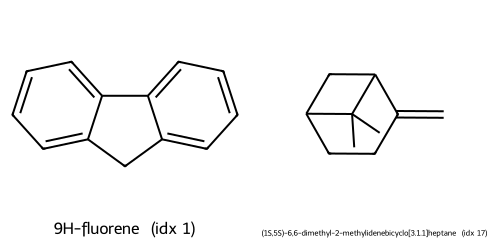


Descriptors UMAP(desc) cluster c1: showing up to 2 molecules


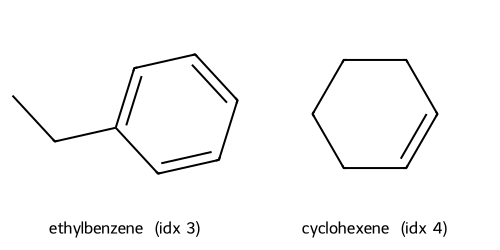


Descriptors UMAP(desc) cluster c2: showing up to 2 molecules


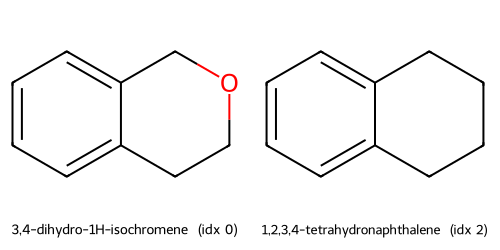

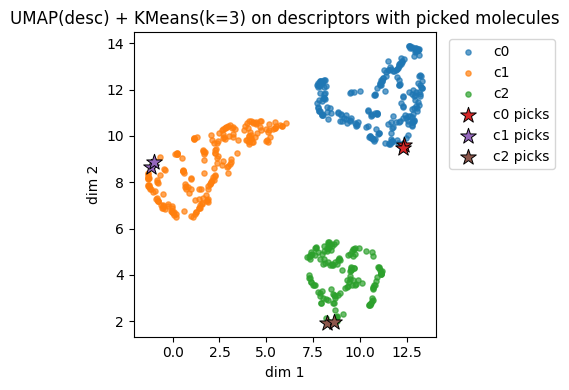

In [13]:
def pick_two_per_cluster(labels):
    picks = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        picks[c] = idx[:2] if len(idx) >= 2 else idx
    return picks

def show_molecules(indices, smiles_col="SMILES", names_col="Compound Name"):
    if not RD:
        print("RDKit not available, cannot draw molecules.")
        return
    mols, legends = [], []
    for i in indices:
        smi = frame.loc[i, smiles_col]
        m = Chem.MolFromSmiles(smi) if smi is not None else None
        mols.append(m)
        legends.append(f"{frame.loc[i, names_col]}  (idx {i})")
    img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(250,250), legends=legends, returnPNG=True)
    display(img)

# 1) pick two per cluster
picks_desc = pick_two_per_cluster(labs_desc)

# 2) draw molecules for each cluster
for c, idxs in picks_desc.items():
    print(f"\nDescriptors {name_desc} cluster c{c}: showing up to 2 molecules")
    show_molecules(idxs)

# 3) star their positions on the existing embedding
plt.figure(figsize=(5,4))
for c in np.unique(labs_desc):
    idx = labs_desc == c
    plt.scatter(Z_desc[idx,0], Z_desc[idx,1], s=14, alpha=0.7, label=f"c{c}")

for c, idxs in picks_desc.items():
    if len(idxs) == 0: 
        continue
    plt.scatter(Z_desc[idxs,0], Z_desc[idxs,1], s=140, marker="*", edgecolor="k", linewidth=0.7, label=f"c{c} picks")

plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.title(f"{name_desc} + KMeans(k=3) on descriptors with picked molecules")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Instead of using descritors, we also try using fingerprints.

Different from **Tanimoto similarity** we used before, this time we demonstrated **Jaccard similarity**. For binary molecular fingerprints (0/1 bits), **Jaccard** and **Tanimoto** are mathematically the same.

**Jaccard similarity**:  
$$
s_J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

**Tanimoto similarity**:  
$$
s_T(A, B) = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$

Since $|A \cup B| = |A| + |B| - |A \cap B|$, we have $s_J = s_T$ for binary fingerprints.

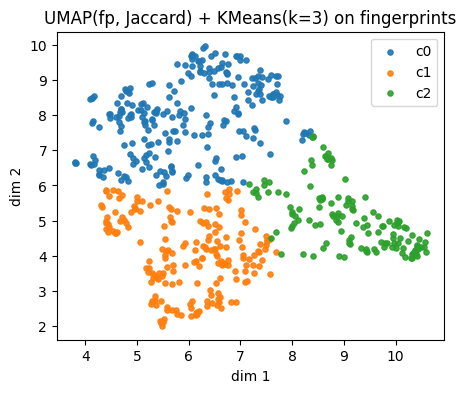

In [14]:
def embed_fingerprints(X_bits_bool, use_umap=True, random_state=0):
    if use_umap and HAVE_UMAP:
        reducer = UMAP(n_neighbors=15, min_dist=0.10, metric="jaccard", random_state=random_state)
        Z = reducer.fit_transform(X_bits_bool)
        name = "UMAP(fp, Jaccard)"
    else:
        D_jac = pairwise_distances(X_bits_bool, metric="jaccard")
        reducer = TSNE(n_components=2, metric="precomputed", perplexity=30,
                       learning_rate="auto", init="random", random_state=random_state)
        Z = reducer.fit_transform(D_jac)
        name = "t-SNE(fp, Jaccard)"
    return Z, name

X_fp_bool = X_fp.astype(bool)
Z_fp, name_fp = embed_fingerprints(X_fp_bool, use_umap=True, random_state=0)

k = 3
km_fp = KMeans(n_clusters=k, random_state=0, n_init=10).fit(Z_fp)
labs_fp = km_fp.labels_

plt.figure(figsize=(5,4))
for c in np.unique(labs_fp):
    idx = labs_fp == c
    plt.scatter(Z_fp[idx,0], Z_fp[idx,1], s=14, alpha=0.9, label=f"c{c}")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.title(f"{name_fp} + KMeans(k={k}) on fingerprints")
plt.legend()
plt.show()



Fingerprints UMAP(fp, Jaccard) cluster c0: showing up to 2 molecules


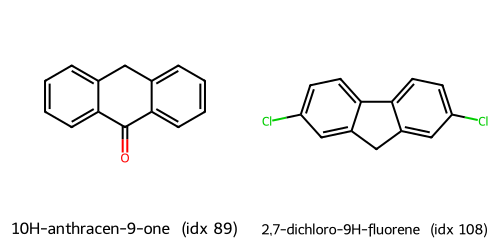


Fingerprints UMAP(fp, Jaccard) cluster c1: showing up to 2 molecules


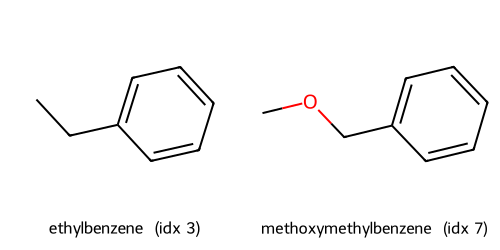


Fingerprints UMAP(fp, Jaccard) cluster c2: showing up to 2 molecules


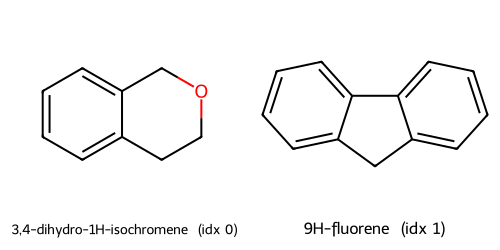

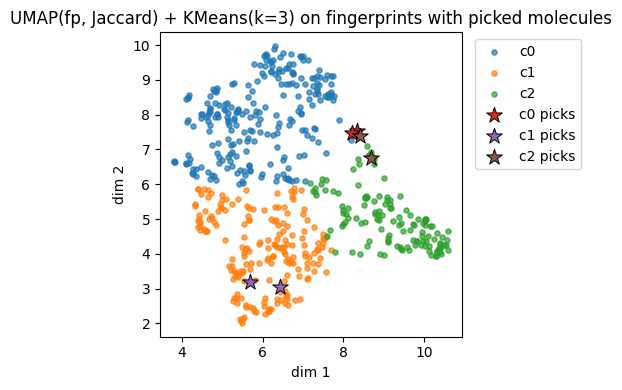

In [15]:
# 1) pick two per cluster
picks_fp = pick_two_per_cluster(labs_fp)

# 2) draw molecules for each cluster
for c, idxs in picks_fp.items():
    print(f"\nFingerprints {name_fp} cluster c{c}: showing up to 2 molecules")
    show_molecules(idxs)

# 3) star their positions on the existing embedding
plt.figure(figsize=(5,4))
for c in np.unique(labs_fp):
    idx = labs_fp == c
    plt.scatter(Z_fp[idx,0], Z_fp[idx,1], s=14, alpha=0.7, label=f"c{c}")

for c, idxs in picks_fp.items():
    if len(idxs) == 0:
        continue
    plt.scatter(Z_fp[idxs,0], Z_fp[idxs,1], s=140, marker="*", edgecolor="k", linewidth=0.7, label=f"c{c} picks")

plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.title(f"{name_fp} + KMeans(k=3) on fingerprints with picked molecules")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

---
## 4. Picking k and validating clusters

Choosing the right number of clusters $k$ is a central step in KMeans.  
If $k$ is too small, distinct groups may be forced together.  
If $k$ is too large, the algorithm may split natural groups unnecessarily.



### 4.1 Elbow plot

KMeans optimizes the **within-cluster sum of squares** (WCSS), often denoted $W_k$:

$
W_k = \sum_{j=1}^k \sum_{x_i \in S_j} \| x_i - c_j \|^2
$

- $S_j$ = the set of points in cluster $j$  
- $c_j$ = the centroid of cluster $j$  
- $\| x_i - c_j \|^2$ = squared Euclidean distance

As $k$ increases, $W_k$ always decreases, since more clusters mean smaller groups.  
But the **rate of decrease slows down**. The "elbow" of the curve marks a good trade-off:  
beyond this point, adding clusters yields little gain.

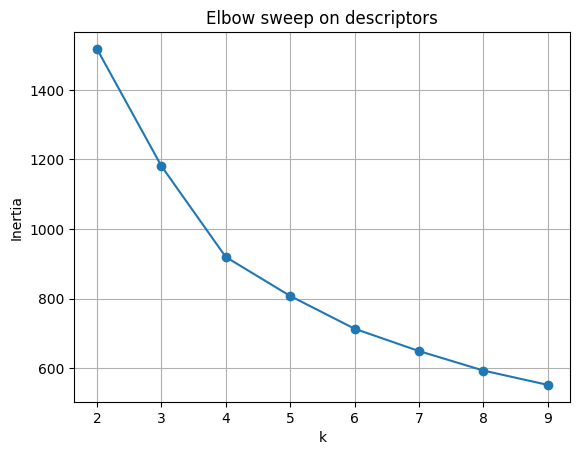

In [16]:
ks = range(2, 10)
inertias = []
for kk in ks:
    km = KMeans(n_clusters=kk, random_state=0, n_init=10).fit(X_desc)
    inertias.append(km.inertia_)

plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow sweep on descriptors")
plt.grid(True)
plt.show()

### 4.2 Silhouette score

Another way to decide $k$ is the **silhouette score**, which measures how well each point fits within its cluster compared to others.

For a point $i$:

1. Let $a(i)$ = average distance of $i$ to all other points in the **same cluster** (intra-cluster distance).  
2. Let $b(i)$ = the minimum average distance of $i$ to points in **any other cluster** (nearest-cluster distance).  

Then the silhouette of point $i$ is:

$
s(i) = \frac{b(i) - a(i)}{\max \{ a(i), b(i) \}}
$

In particular:

- $s(i)$ ranges in $[-1, 1]$.  
- $s(i) \approx 1$: point is well clustered (much closer to its own cluster than others).  
- $s(i) \approx 0$: point is on a boundary between clusters.  
- $s(i) < 0$: point may be misclassified (closer to another cluster).  

Take home messgae: higher $S$ the better.

In [17]:
sil = []
for kk in ks:
    km = KMeans(n_clusters=kk, random_state=0, n_init=10).fit(X_desc)
    sil.append(silhouette_score(X_desc, km.labels_))

pd.DataFrame({"k": list(ks), "silhouette": np.round(sil,3)})

,k,silhouette
0,2,0.353
1,3,0.371
2,4,0.325
3,5,0.296
4,6,0.276
5,7,0.284
6,8,0.264
7,9,0.263


Visualize the silhouette for a chosen k.

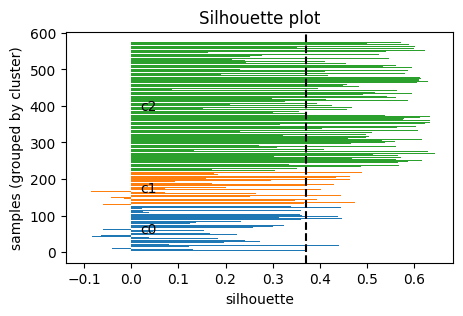

In [18]:
def plot_silhouette(X, labels):
    s = silhouette_samples(X, labels)
    order = np.argsort(labels)
    s_sorted = s[order]
    lbl_sorted = np.array(labels)[order]
    plt.figure(figsize=(5,3))
    y0 = 0
    for c in np.unique(lbl_sorted):
        vals = s_sorted[lbl_sorted == c]
        y1 = y0 + len(vals)
        plt.barh(np.arange(y0, y1), vals, edgecolor="none")
        plt.text(0.02, (y0+y1)/2, f"c{c}", va="center")
        y0 = y1
    plt.xlabel("silhouette")
    plt.ylabel("samples (grouped by cluster)")
    plt.title("Silhouette plot")
    plt.axvline(np.mean(s), color="k", linestyle="--")
    plt.show()

plot_silhouette(X_desc, labels_km)

```{admonition} ⏰ **Exercise 4**

In section 3, we also have `Z_desc` from either t-sne or umap, try to use `Z_desc` to calcuate elbow and silhouette.

We also have `Z_fp`, try to use it to make the plot as well.

```

---

## 5. Alternative clustering methods


KMeans assumes clusters are roughly spherical and similar in size.  
But real chemical or molecular data may not follow this pattern.  
That is why it is useful to explore **alternative clustering methods** that can adapt to different cluster shapes.



### 5.1 Agglomerative (Ward)

Agglomerative clustering is a **hierarchical method**.  
It does not start with predefined cluster centers. Instead, it begins by treating each point as its own cluster and then **merges clusters step by step** until only $k$ remain. Here are the steps:

1. **Initialization**: each point is its own cluster.  
2. **Iteration**: repeatedly merge the two clusters that are closest.  
3. **Stop** when exactly $k$ clusters remain.


Different definitions of "closest" give different results.  
The **Ward method** merges the two clusters that cause the smallest increase in within-cluster variance.

Formally, at each step it chooses the merge that minimizes the increase of:

$
\sum_{j=1}^{k} \sum_{x_i \in S_j} \| x_i - c_j \|^2
$

This is similar to the KMeans objective, but built hierarchically rather than iteratively reassigning points.

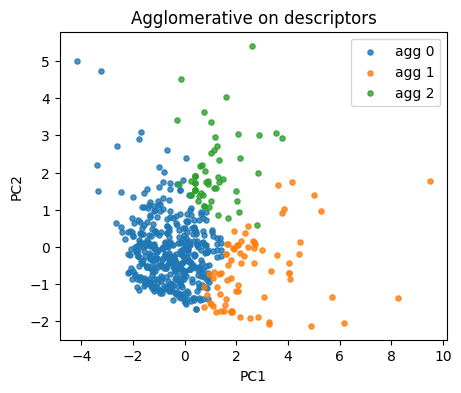

ARI: 0.018 NMI: 0.075


In [19]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
lab_agg = agg.fit_predict(X_desc)

plt.figure(figsize=(5,4))
for lab in np.unique(lab_agg):
    idx = lab_agg == lab
    plt.scatter(Z[idx,0], Z[idx,1], s=14, alpha=0.8, label=f"agg {lab}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Agglomerative on descriptors")
plt.legend(); plt.show()

if y_reac.nunique() > 1:
    print("ARI:", round(adjusted_rand_score(y_reac, lab_agg), 3),
          "NMI:", round(normalized_mutual_info_score(y_reac, lab_agg), 3))

### 5.2 DBSCAN

Unlike KMeans or Agglomerative, **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) does not require $k$ in advance.  
Instead, it groups points based on density and labels sparse points as noise The key ideas are:

- A point is a core point if at least `min_samples` neighbors fall within radius $\varepsilon$ (epsilon).  
- Points within $\varepsilon$ of a core point are part of the same cluster.  
- Clusters expand outward from core points.  
- Points not reachable from any core point are labeled noise ($-1$).

So, why DBSCAN is useful? It can find **non-spherical** clusters (e.g., moons, rings). As we will see for the example below. Also it handles noise explicitly and does not force every point into a cluster.  

But: results depend strongly on $\varepsilon$ and `min_samples`.

In [20]:
db = DBSCAN(eps=0.65, min_samples=5).fit(X_desc)
lab_db = db.labels_
np.unique(lab_db, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([ 90, 154, 117, 161,  16,  37]))

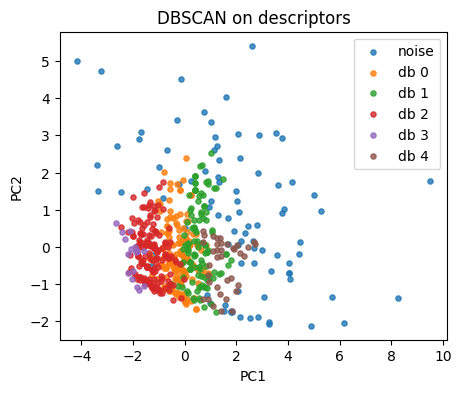

In [21]:
plt.figure(figsize=(5,4))
for lab in np.unique(lab_db):
    idx = lab_db == lab
    name = "noise" if lab == -1 else f"db {lab}"
    plt.scatter(Z[idx,0], Z[idx,1], s=14, alpha=0.8, label=name)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("DBSCAN on descriptors")
plt.legend(); plt.show()

Tip: tune `eps` by scanning a small grid.

In [22]:
eps_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2]
rows = []
for e in eps_grid:
    db = DBSCAN(eps=e, min_samples=8).fit(X_desc)
    labs = db.labels_
    n_noise = np.sum(labs == -1)
    n_clu = len(np.unique(labs[labs!=-1]))
    rows.append({"eps": e, "n_clusters": n_clu, "n_noise": int(n_noise)})
pd.DataFrame(rows)

,eps,n_clusters,n_noise
0,0.1,1,567
1,0.2,3,526
2,0.3,8,365
3,0.4,6,217
4,0.5,4,168
5,0.6,5,133
6,0.7,1,99
7,0.8,1,63
8,1.0,1,42
9,1.2,1,28


Below are some examples for you to get a better idea on their difference.

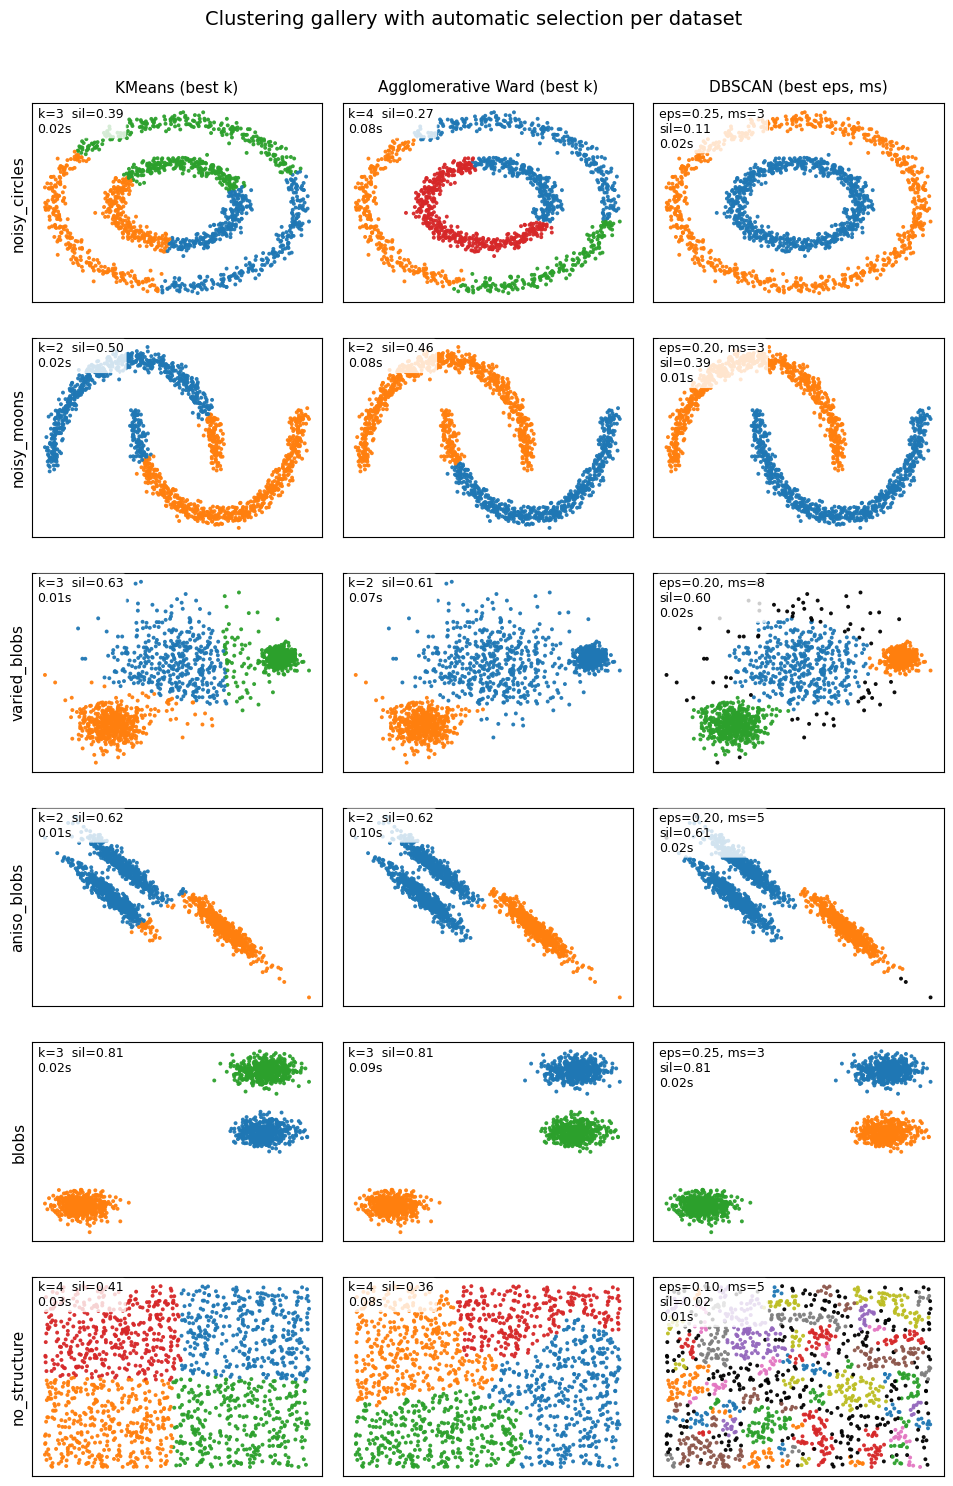

In [23]:
"""
- Column 1: KMeans. Pick k by highest silhouette.
- Column 2: Agglomerative (Ward). Pick k by highest silhouette.
- Column 3: DBSCAN. Pick eps and min_samples by highest silhouette.
"""

import time
import warnings
from itertools import cycle, islice

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

# ---------------------------
# 1) Build toy datasets with different structure
# ---------------------------
n_samples = 1500
rng_seed = 170

noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=rng_seed)
noisy_moons   = make_moons(n_samples=n_samples, noise=0.05, random_state=rng_seed)
blobs         = make_blobs(n_samples=n_samples, random_state=8)

# Anisotropic blobs via linear transform
X_aniso, y_aniso = make_blobs(n_samples=n_samples, random_state=rng_seed)
transformation = np.array([[0.6, -0.6],
                           [-0.4, 0.8]])
X_aniso = X_aniso @ transformation
aniso = (X_aniso, y_aniso)

# Blobs with varied variances
varied = make_blobs(n_samples=n_samples,
                    cluster_std=[1.0, 2.5, 0.5],
                    random_state=rng_seed)

# No structure cloud
rs = np.random.RandomState(rng_seed)
no_structure = (rs.rand(n_samples, 2), None)

datasets = [
    ("noisy_circles", noisy_circles),
    ("noisy_moons",   noisy_moons),
    ("varied_blobs",  varied),
    ("aniso_blobs",   aniso),
    ("blobs",         blobs),
    ("no_structure",  no_structure),
]

# ---------------------------
# 2) Color helper
# ---------------------------
base_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c",
    "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22"
]

def colors_for_labels(y_pred, noise_color="#000000"):
    """
    Map cluster labels to colors.
    DBSCAN noise points labeled as -1 get black.
    """
    y_pred = np.asarray(y_pred).ravel()
    pos = y_pred[y_pred >= 0]
    n_labels = int(pos.max()) + 1 if pos.size else 1
    palette = np.array(list(islice(cycle(base_colors), n_labels)))
    col = palette[np.clip(y_pred, 0, n_labels - 1)]
    col[y_pred == -1] = noise_color
    return col

# ---------------------------
# 3) Scoring utility
# ---------------------------
def safe_silhouette(X, labels):
    """
    Return silhouette score if valid. Otherwise a very low score.
    Valid means at least 2 clusters and no single-cluster assignment.
    """
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    # Remove noise for the check when all are noise
    if len(uniq) == 1:
        return -1e9
    # If DBSCAN produced only noise and one cluster, also invalid
    if np.all(labels == -1):
        return -1e9
    # Check at least 2 non-noise clusters
    nn = labels[labels != -1]
    if nn.size == 0 or np.unique(nn).size < 2:
        return -1e9
    try:
        return silhouette_score(X, labels)
    except Exception:
        return -1e9

# ---------------------------
# 4) Model selection per method
# ---------------------------
def select_kmeans(X, k_range=range(2, 5)):
    best = {"score": -1e9, "k": None, "labels": None, "fit_time": 0.0}
    for k in k_range:
        km = cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
        t0 = time.time()
        labels = km.fit_predict(X)
        fit_t = time.time() - t0
        score = safe_silhouette(X, labels)
        if score > best["score"]:
            best = {"score": score, "k": k, "labels": labels, "fit_time": fit_t}
    return best

def select_ward(X, k_range=range(2, 5), n_neighbors=10):
    # Build a sparse graph to encourage local merges
    connectivity = kneighbors_graph(X, n_neighbors=n_neighbors, include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    best = {"score": -1e9, "k": None, "labels": None, "fit_time": 0.0}
    for k in k_range:
        ward = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward", connectivity=connectivity)
        t0 = time.time()
        labels = ward.fit_predict(X)
        fit_t = time.time() - t0
        score = safe_silhouette(X, labels)
        if score > best["score"]:
            best = {"score": score, "k": k, "labels": labels, "fit_time": fit_t}
    return best

def select_dbscan(X, eps_grid=None, min_samples_grid=(3, 5, 8)):
    # If eps grid not given, make a small sweep adapted to standardized data
    if eps_grid is None:
        eps_grid = np.linspace(0.05, 0.5, 10)
    best = {"score": -1e9, "eps": None, "min_samples": None, "labels": None, "fit_time": 0.0}
    for eps in eps_grid:
        for ms in min_samples_grid:
            db = cluster.DBSCAN(eps=eps, min_samples=ms)
            t0 = time.time()
            labels = db.fit_predict(X)
            fit_t = time.time() - t0
            score = safe_silhouette(X, labels)
            if score > best["score"]:
                best = {"score": score, "eps": eps, "min_samples": ms, "labels": labels, "fit_time": fit_t}
    return best

# ---------------------------
# 5) Figure layout: 6 rows x 3 columns
# ---------------------------
n_rows = len(datasets)
n_cols = 3
fig = plt.figure(figsize=(n_cols * 3.2, n_rows * 2.6))
plt.subplots_adjust(left=.04, right=.99, bottom=.04, top=.92, wspace=.07, hspace=.18)

col_titles = ["KMeans (best k)", "Agglomerative Ward (best k)", "DBSCAN (best eps, ms)"]

plot_idx = 1
for row_i, (ds_name, ds) in enumerate(datasets):
    X, y = ds
    # Standardize for fair distance use
    X = StandardScaler().fit_transform(X)

    # KMeans
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best_km = select_kmeans(X)
    ax = plt.subplot(n_rows, n_cols, plot_idx); plot_idx += 1
    cols = colors_for_labels(best_km["labels"])
    ax.scatter(X[:, 0], X[:, 1], s=8, c=cols, linewidths=0, alpha=0.95)
    if row_i == 0:
        ax.set_title(col_titles[0], fontsize=11, pad=8)
    ax.set_ylabel(ds_name, fontsize=11) if (plot_idx - 2) % 3 == 0 else None
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.02, 0.98, f"k={best_km['k']}  sil={best_km['score']:.2f}\n{best_km['fit_time']:.2f}s",
            transform=ax.transAxes, ha="left", va="top", fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.8, edgecolor="none"))

    # Ward
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best_wd = select_ward(X)
    ax = plt.subplot(n_rows, n_cols, plot_idx); plot_idx += 1
    cols = colors_for_labels(best_wd["labels"])
    ax.scatter(X[:, 0], X[:, 1], s=8, c=cols, linewidths=0, alpha=0.95)
    if row_i == 0:
        ax.set_title(col_titles[1], fontsize=11, pad=8)
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.02, 0.98, f"k={best_wd['k']}  sil={best_wd['score']:.2f}\n{best_wd['fit_time']:.2f}s",
            transform=ax.transAxes, ha="left", va="top", fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.8, edgecolor="none"))

    # DBSCAN
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best_db = select_dbscan(X)
    ax = plt.subplot(n_rows, n_cols, plot_idx); plot_idx += 1
    cols = colors_for_labels(best_db["labels"])
    ax.scatter(X[:, 0], X[:, 1], s=8, c=cols, linewidths=0, alpha=0.95)
    if row_i == 0:
        ax.set_title(col_titles[2], fontsize=11, pad=8)
    ax.set_xticks([]); ax.set_yticks([])
    label = f"eps={best_db['eps']:.2f}, ms={best_db['min_samples']}"
    ax.text(0.02, 0.98, f"{label}\nsil={best_db['score']:.2f}\n{best_db['fit_time']:.2f}s",
            transform=ax.transAxes, ha="left", va="top", fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.8, edgecolor="none"))

fig.suptitle("Clustering gallery with automatic selection per dataset", fontsize=14)
plt.show()

---


---
## 6. Glossary

```{glossary}

clustering
    Group samples using only $X$, no labels during fit.

KMeans
    A clustering algorithm that assigns points to k centroids, updating assignments and centroids to minimize within-cluster variance.

Agglomerative clustering
    A hierarchical algorithm that starts with each point as its own cluster and merges clusters step by step until k remain.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
    A density-based clustering method that groups points when they have enough neighbors within a radius. Points that don’t belong to any dense region are labeled noise.

elbow method
    A heuristic for selecting the number of clusters in KMeans by plotting inertia vs k. The "elbow" marks diminishing returns from adding more clusters.

silhouette score
    A metric for clustering quality. For each point, compares average distance to its own cluster vs the nearest other cluster. Ranges from -1 (bad) to +1 (good).

Tanimoto / Jaccard similarity
    For binary fingerprints, both measure overlap divided by union. Often used to compare molecular fingerprints in chemoinformatics.


```
---
## 7. In-class activity

### Q1. t-SNE on 10 descriptors
Rebuild features using 10 descriptors, embed with t-SNE, plot in 2D.

Hint: copy and use function `def calc_descriptors10(smiles: str)` from Lecture 11 if you forget how to define the 10 descriptor.
```python
# TO DO
```

### Q2. Elbow on KMeans
Choose a reasonable k by inertia.

1) Fit `KMeans` for k in {2..9}.
2) Record `inertia_` for each k.
3) Plot `inertia` vs `k` and inspect the elbow.
```python
# TO DO
```



### Q3. Silhouette on KMeans
Choose k by separation vs compactness.

1) Fit `KMeans` for k in {2..9}.
2) Compute `silhouette_score()` for each k.
3) Plot `silhouette` vs `k`. Report the best k by this metric.

```python
# TO DO
```



### Q4. Agglomerative sweep with plots
Compare another clustering model and visualize the chosen solution.

1) For k in {2..9}, fit `AgglomerativeClustering(linkage="ward")`.
2) Compute the silhouette for each k and plot `silhouette` vs `k`.
3) Pick the best k by silhouette, refit, then plot the cluster assignments on the same t-SNE plane from Q1.

```python
# TO DO
```

---

## 8. Solutions

**Q1**

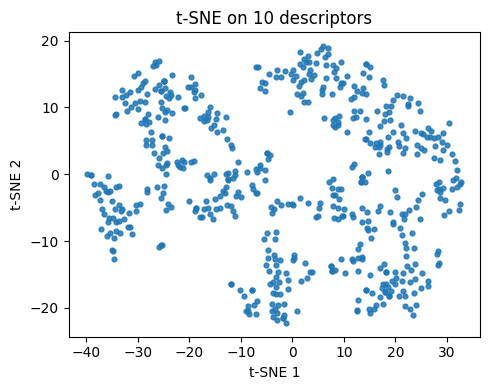

In [24]:
# Q1. t-SNE on 10 descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes df_raw is already loaded and RDKit imports exist:
# from rdkit import Chem
# from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors

def calc_descriptors10(smiles: str):
    m = Chem.MolFromSmiles(smiles)
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
        "NumHAcceptors": rdMolDescriptors.CalcNumHBA(m),
        "NumHDonors": rdMolDescriptors.CalcNumHBD(m),
        "NumRotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(m),
        "HeavyAtomCount": Descriptors.HeavyAtomCount(m),
        "FractionCSP3": rdMolDescriptors.CalcFractionCSP3(m),
        "NumAromaticRings": rdMolDescriptors.CalcNumAromaticRings(m)
    })

# 10 descriptors
desc10 = df_raw["SMILES"].apply(calc_descriptors10)
df10 = pd.concat([df_raw.reset_index(drop=True), desc10.reset_index(drop=True)], axis=1)

cols10 = [
    "MolWt","LogP","TPSA","NumRings","NumHAcceptors",
    "NumHDonors","NumRotatableBonds","HeavyAtomCount",
    "FractionCSP3","NumAromaticRings"
]
scaler10 = StandardScaler().fit(df10[cols10])
X10 = scaler10.transform(df10[cols10])

# t-SNE embedding for descriptors (reused in Q4 and Q5)
tsne10 = TSNE(n_components=2, perplexity=30, learning_rate="auto",
              init="pca", metric="euclidean", random_state=0)
Z10 = tsne10.fit_transform(X10)

plt.figure(figsize=(5,4))
plt.scatter(Z10[:,0], Z10[:,1], s=12, alpha=0.85)
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.title("t-SNE on 10 descriptors")
plt.tight_layout()
plt.show()


**Q2**

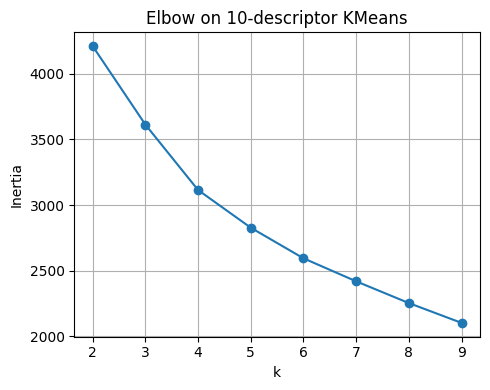

,k,inertia
0,2,4210.881
1,3,3612.879
2,4,3114.660
3,5,2827.642
4,6,2594.569
5,7,2419.247
6,8,2253.512
7,9,2102.564


In [25]:
# Q2. Elbow on KMeans (k=2..9)

ks = range(2, 10)
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X10)
    inertias.append(km.inertia_)

plt.figure(figsize=(5,4))
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.title("Elbow on 10-descriptor KMeans")
plt.grid(True); plt.tight_layout()
plt.show()

pd.DataFrame({"k": list(ks), "inertia": inertias}).round(3)

**Q3**

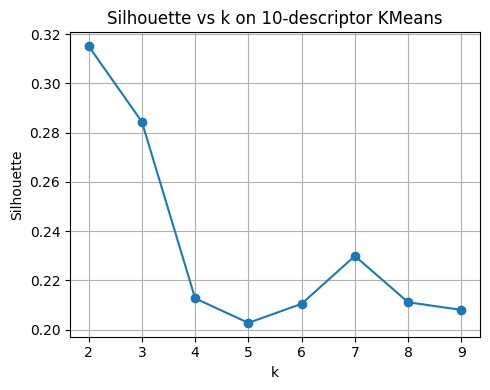

Best k by silhouette: 2


,k,silhouette
0,2,0.315
1,3,0.284
2,4,0.213
3,5,0.203
4,6,0.210
5,7,0.230
6,8,0.211
7,9,0.208


In [26]:
# Q3. Silhouette on KMeans (k=2..9)
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X10)
    sil_scores.append(silhouette_score(X10, km.labels_))

plt.figure(figsize=(5,4))
plt.plot(list(ks), sil_scores, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("Silhouette vs k on 10-descriptor KMeans")
plt.grid(True); plt.tight_layout()
plt.show()

best_k_sil = list(ks)[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k_sil)
pd.DataFrame({"k": list(ks), "silhouette": np.round(sil_scores, 3)})


**Q4**

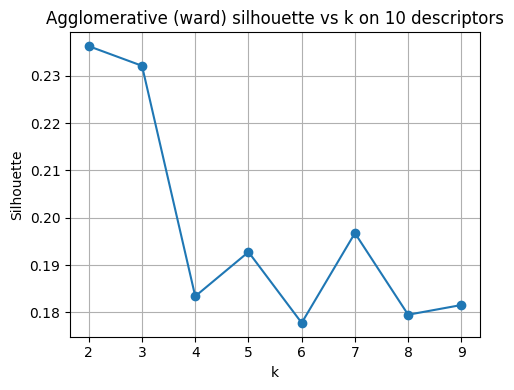

Best k for Agglomerative by silhouette: 2


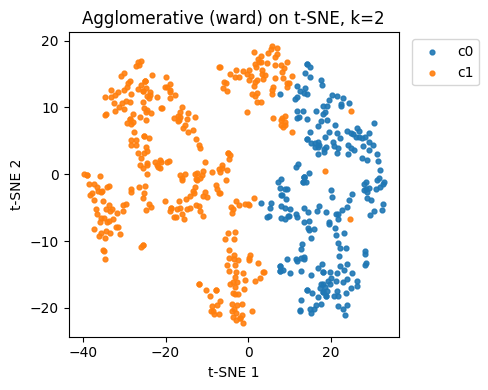

In [27]:
# Q4. Agglomerative sweep with plots
sil_agg = []
for k in ks:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels_agg = agg.fit_predict(X10)
    sil_agg.append(silhouette_score(X10, labels_agg))

plt.figure(figsize=(5,4))
plt.plot(list(ks), sil_agg, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("Agglomerative (ward) silhouette vs k on 10 descriptors")
plt.grid(True); plt.tight_layout()
plt.show()

best_k_agg = list(ks)[int(np.argmax(sil_agg))]
print("Best k for Agglomerative by silhouette:", best_k_agg)

# Fit best k and plot clusters on t-SNE plane (Z10)
agg_best = AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward")
labels_agg_best = agg_best.fit_predict(X10)

plt.figure(figsize=(5,4))
for c in np.unique(labels_agg_best):
    idx = labels_agg_best == c
    plt.scatter(Z10[idx,0], Z10[idx,1], s=12, alpha=0.9, label=f"c{c}")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.title(f"Agglomerative (ward) on t-SNE, k={best_k_agg}")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()